<a href="https://colab.research.google.com/github/hansglick/book_errata/blob/main/p010_Custom_Loop_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import numpy as np
import tensorflow as tf
import os
from IPython.display import clear_output
import matplotlib.pyplot as plt
print(tf.__version__)

2.8.2


# Objectif

Designer un GAN et entraîner via un custom loop :
 * Créer un discriminator avec API Sequential
   * Photo 28*28 Noir et Blanc
   * Convolution, filters = 64, kernel = (3,3), strides = (2,2), padding "same"
   * LeakyRelu, alpha = 0.2
   * Convolution, filters = 128, kernel = (3,3), strides = (2,2), padding "same"
   * LeakyRelu, alpha = 0.2
   * GlobalMaxPooling2D
   * Dense, unit = 1
 * Créer le générateur avec API Sequential
   * Input de taille 128
   * Dense de 7*7*128 units
   * LeakyRelu alpha 0.2
   * Reshape afin d'avoir une image 7,7,128
   * Conv2DTranspose, avec filters = 128, kernel = (4,4), strides = (2,2) padding "same"
   * LeakyRelu alpha 0.2
   * Conv2DTranspose, avec filters = 128, kernel = (4,4), strides = (2,2) padding "same"
   * Conv2d, filters = 1, kernels = 7,7, padding same, activation sigmoid
 * Instancier les optimizers pour les deux modeles
 * Instancier une loss binary pour logits
 * Wrapping via un decorateur pr le mode graph de la fonction qui se charge d'un training step :     
   * input image réelle
   * Draw random normal points de taille égale batch,latent dim (128)
   * Decode les random points via le generateur
   * Concaténer les fake images et des vrai images via `tf.concat([generated_images, real_images], axis=0)`
   * Soustraire au vecteur concaténation construit ci-dessus de l'uniform * 0.5, ce serait un trick important apparemment
   * Mettre à jour les gradients du discriminator
   * Sampler des random points dans le latent space batch size, latent dim
   * Création d'un misleading labels vector qui est en fait un veteur colonne de taille batch size rempli de zéros
   * Mise à jour des poids du generateur, assez subtil donc je le mis ici, j'ai pas compris grand chose au GAN
   * Renvoyer le triplet :  d_loss, g_loss, generated_images

``
predictions = discriminator(generator(random_latent_vectors))
g_loss = loss_fn(misleading_labels, predictions)
grads = tape.gradient(g_loss, generator.trainable_weights)
g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
``

 * Préparation du dataset
   * batch 64
   * `keras.datasets.mnist.load_data()`
   * prendre les données du train et du test et les concaténer dans un seul dataset
   * Pourquoi np.reshape(all_digits, (-1, 28, 28, 1))
   * buffer_size=1024
   * /255 et float
   * fix epoch to 20, attention ce peut être très long
 * Créer la custom loop, sur epoch, batch
   * Appeler le train step
   * Création de la log avec affichage loss discriminator et generator
   * Afficher une image générer de temps à autre via `tf.keras.preprocessing.image.array_to_img`

In [81]:
# Création du discriminator 
#   * Photo 28*28 Noir et Blanc
#   * Convolution, filters = 64, kernel = (3,3), strides = (2,2), padding "same"
#   * LeakyRelu, alpha = 0.2
#   * Convolution, filters = 128, kernel = (3,3), strides = (2,2), padding "same"
#   * LeakyRelu, alpha = 0.2
#   * GlobalMaxPooling2D
#   * Dense, unit = 1

discriminator = tf.keras.Sequential([
                                     tf.keras.layers.Input(shape=(28,28,1),dtype = "float32"),

                                     tf.keras.layers.Conv2D(filters = 64,
                                                            kernel_size = (3,3),
                                                            strides = (2,2),
                                                            padding="same"),

                                     tf.keras.layers.LeakyReLU(alpha=0.2),

                                     tf.keras.layers.Conv2D(filters=128,
                                                            kernel_size=(3,3),
                                                            strides=(2,2),
                                                            padding="same"),
                                     
                                     tf.keras.layers.LeakyReLU(alpha=0.2),

                                     tf.keras.layers.GlobalMaxPooling2D(),

                                     tf.keras.layers.Dense(units=1)
],name="discriminator")

In [82]:
# Création du Generator
#   * Input de taille 128
#   * Dense de 7*7*128 units
#   * LeakyRelu alpha 0.2
#   * Reshape afin d'avoir une image 7,7,128
#   * Conv2DTranspose, avec filters = 128, kernel = (4,4), strides = (2,2) padding "same"
#   * LeakyRelu alpha 0.2
#   * Conv2DTranspose, avec filters = 128, kernel = (4,4), strides = (2,2) padding "same"
#   * Conv2d, filters = 1, kernels = 7,7, padding same, activation sigmoid

generator = tf.keras.Sequential([
                 tf.keras.layers.Input(shape=(128,),dtype="float32"),

                 tf.keras.layers.Dense(units=7*7*128),

                 tf.keras.layers.LeakyReLU(alpha=0.2),

                 tf.keras.layers.Reshape(target_shape=(7,7,128)),

                 tf.keras.layers.Conv2DTranspose(filters=128,
                                                 kernel_size=(4,4),
                                                 strides=(2,2),
                                                 padding="same"),

                 tf.keras.layers.LeakyReLU(alpha=0.2),

                 tf.keras.layers.Conv2DTranspose(filters=128,
                                                 kernel_size=(4,4),
                                                 strides=(2,2),
                                                 padding="same"),

                 tf.keras.layers.Conv2D(filters=1,
                                        kernel_size=(7,7),
                                        padding="same",
                                        activation="sigmoid")                 
],name="generator")

In [83]:
# Instancier optimizer du generator, du discriminator, et la loss binary
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0004)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [84]:
# Autres parameters
batch_size = 64

In [85]:
# Function training step
#   * input image réelle
#   * Draw random normal points de taille égale batch,latent dim (128)
#   * Decode les random points via le generateur
#   * Concaténer les fake images et des vrai images via `tf.concat([generated_images, real_images], axis=0)`
#   * Soustraire au vecteur concaténation construit ci-dessus de l'uniform * 0.5, ce serait un trick important apparemment
#   * Mettre à jour les gradients du discriminator
#   * Sampler des random points dans le latent space batch size, latent dim
#   * Création d'un misleading labels vector qui est en fait un veteur colonne de taille batch size rempli de zéros
#   * Mise à jour des poids du generateur, assez subtil donc je le mis ici, j'ai pas compris grand chose au GAN
#   * Renvoyer le triplet :  d_loss, g_loss, generated_images
#``
#predictions = discriminator(generator(random_latent_vectors))
#g_loss = loss_fn(misleading_labels, predictions)
#grads = tape.gradient(g_loss, generator.trainable_weights)
#g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
#``

@tf.function
def training_step(batch_images_real):

  # Génération d'un vecteur bruit latent de taille 128
  noise = tf.random.normal(shape=(batch_size,128))

  # Génération d'images à partir du bruit
  generated_images = generator(noise)

  # Création d'un dataset avec fake images label 1, images réelles label 0
  images_dataset = tf.concat([generated_images,batch_images_real],axis=0)
  z = tf.zeros(shape=(batch_size,1))
  o = tf.ones(shape=(batch_size,1))
  labels = tf.concat([o,z],axis=0)

  # Bruiter le vecteur labels
  labels = labels + 0.5 * tf.random.normal(shape=labels.shape)

  # Mise à jour des poids du discriminator
  with tf.GradientTape() as tape:

    # Prédictions du discriminator
    # Calcul de la loss
    discriminator_predictions = discriminator(images_dataset)
    discriminator_loss = loss(labels,discriminator_predictions)
  
  # Calcul des gradients
  # Mise à jour des poids
  grads = tape.gradient(discriminator_loss,discriminator.trainable_weights)
  discriminator_optimizer.apply_gradients(zip(grads,discriminator.trainable_weights))


  # * * * 

  # Générer du bruit dans l'espace latent
  noise = tf.random.normal(shape=(batch_size,128))

  # Création du missleading labels, des labels représentant des réelles images
  missleading_labels = tf.zeros(shape=(batch_size,1))

  # Mise à jour des poids du générateur
  with tf.GradientTape() as tape:

    # Predictions du discriminator des images nouvellement générées par le generateur
    predicted_images = discriminator(generator(noise))
    generator_loss = loss(missleading_labels,predicted_images)

  # Récupération des gradients
  # Mise à jour des poids du generator
  grads = tape.gradient(generator_loss,generator.trainable_weights)
  generator_optimizer.apply_gradients(zip(grads,generator.trainable_weights))

  
  # retourner le triplet generator_loss,discriminator_loss,generated_images
  return generator_loss,discriminator_loss,generated_images




In [86]:
# Préparation du dataset
#   * batch 64
#   * `keras.datasets.mnist.load_data()`
#   * prendre les données du train et du test et les concaténer dans un seul dataset
#   * Pourquoi np.reshape(all_digits, (-1, 28, 28, 1))
#   * buffer_size=1024
#   * /255 et float
#   * fix epoch to 20, attention ce peut être très long

(xtrain,_),(xtest,_) = tf.keras.datasets.mnist.load_data()
all_digits = np.concatenate((xtrain,xtest),axis=0)
all_digits = np.reshape(all_digits,newshape=(-1,28,28,1))
all_digits = all_digits / 255.0
all_digits = all_digits.astype("float32")
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(64)

epochs = 1

Steps : 0 | Generator Loss : 0.668459. 
Steps : 0 | Discriminator Loss : 0.685247. 


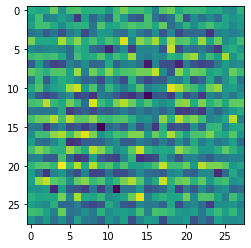

Steps : 10 | Generator Loss : 0.710447. 
Steps : 10 | Discriminator Loss : 0.617268. 


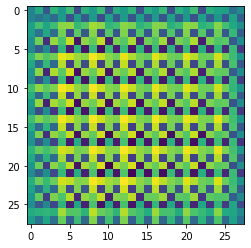

Steps : 20 | Generator Loss : 0.781457. 
Steps : 20 | Discriminator Loss : 0.573720. 


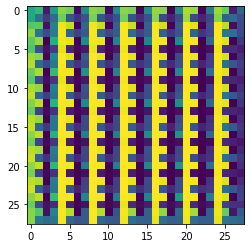

Steps : 30 | Generator Loss : 0.928972. 
Steps : 30 | Discriminator Loss : 0.448133. 


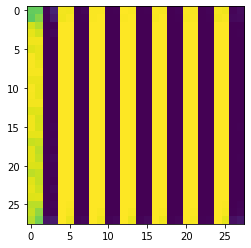

Steps : 40 | Generator Loss : 1.171865. 
Steps : 40 | Discriminator Loss : 0.355927. 


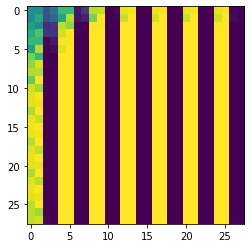

Steps : 50 | Generator Loss : 0.991007. 
Steps : 50 | Discriminator Loss : 0.339932. 


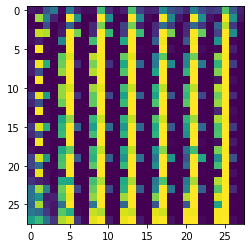

Steps : 60 | Generator Loss : 0.368858. 
Steps : 60 | Discriminator Loss : 0.732897. 


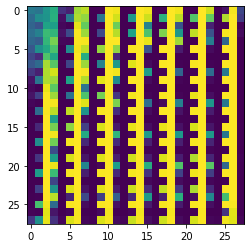

Steps : 70 | Generator Loss : 0.777587. 
Steps : 70 | Discriminator Loss : 0.592743. 


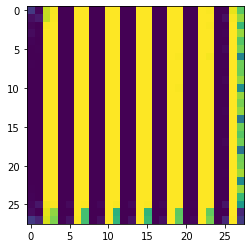

Steps : 80 | Generator Loss : 1.172569. 
Steps : 80 | Discriminator Loss : 0.330690. 


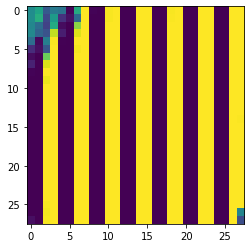

Steps : 90 | Generator Loss : 0.881583. 
Steps : 90 | Discriminator Loss : 0.376504. 


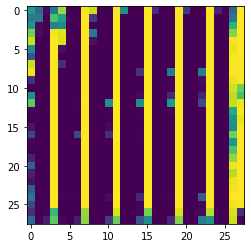

In [ ]:
# Créer la custom loop
#   * Appeler le train step
#   * Création de la log avec affichage loss discriminator et generator
#   * Afficher une image générer de temps à autre via `tf.keras.preprocessing.image.array_to_img`

for _ in range(epochs):

  for step,batch_data in enumerate(dataset):

    # Le training step
    generator_loss,discriminator_loss, generated_images = training_step(batch_data)

    # Affichage des logs tout les 200 steps (batchs)
    if step % 10 == 0:
      print("Steps : %d | Generator Loss : %2f. " % (step,generator_loss))
      print("Steps : %d | Discriminator Loss : %2f. " % (step,discriminator_loss))


      # Enregistrement d'une image générée
      # tf.keras.preprocessing.image.array_to_img prend un numpy array 0-255
      # Le scale doit etre défini à False
      # On sauve ensuite l'image au format PNG avec la méthode .save(path)
      img = tf.keras.preprocessing.image.array_to_img(generated_images[0] * 255, scale = False)
      path_image = os.path.join("./","generated_"+str(step)+".png")
      
      #clear_output()
      image_array = generated_images[0].numpy().squeeze()
      plt.imshow( image_array * 255)
      plt.show()


    # On stoppe l'apprentissage, car c'est trèslong
    if step > 1000:
      break


In [ ]:
# A faire
# Comprendre pourquoi on peut pas rescale sur un dataset.map(lambda a : a/255.)

# A savoir
# Conv2D réduit une image, augumente sa profondeur
# Upsampling agrandit une image bêtement
# Conv2Transpose agrandit une image en apprenant des poids
# Pour concaténer des tensors : tf.concat([generated_images, real_images], axis=0)
# Afin de rajouter une dimension, pour passer de 700,28,28 à 700,28,28,1 : np.reshape(all_digits,newshape=(-1,28,28,1))
# Bonne pratique pourles logs : print("discriminator loss at step %d: %.2f" % (step, d_loss))